## Menú del Proyecto de Predicción de Rotación de Clientes en Beta Bank

1. [Introducción](#introducción)
2. [Libreiras y dependencias](#librerias)
3. [Descargar y Cargar los Datos](#descargar-y-cargar-los-datos)
4. [Explorar los Datos](#explorar-los-datos)
5. [Preprocesamiento de Datos](#preprocesamiento-de-datos)
6. [Entrenar un modelo sin tener en cuenta el desequilibrio de clases](#explorar-el-equilibrio-de-clases)
7. [Evaluar el modelo baseline](#evaluar-un-modelo-baseline)
8. [Mejorar el modelo considerando el desequilibrio de clases](#mejorar-el-modelo-con-balance-de-clases)
9. [Evaluar el modelo mejorado](#evaluar-el-modelo-mejorado)
10. [Conclusión](#conclusion)
10. [Resumen](#resumen)


# Introducción <a id='introduccion'></a>

Beta Bank ha observado una tendencia de deserción de clientes mes tras mes, lo que representa un desafío significativo para el banco. La administración ha determinado que retener a los clientes existentes es más rentable que atraer nuevos. Para abordar este problema, es esencial predecir con anticipación si un cliente tiene la intención de abandonar el banco. Contamos con datos históricos sobre el comportamiento de los clientes y las terminaciones de contratos, los cuales serán utilizados para desarrollar un modelo predictivo que permita identificar a los clientes en riesgo y mejorar las estrategias de retención.

# Importar las bibliotecas necesarias <a id='librerias'></a>


In [5]:
# Importar las bibliotecas necesarias
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
import seaborn as sns

# Descargar y Cargar los Datos <a id='descargar-y-cargar-los-datos'></a>

In [6]:
#->datos
# Leer el archivo y almacenarlo en df
def cargar_archivos_con_separadores(archivos_con_separadores):
    """
    Carga múltiples archivos CSV con separadores específicos para cada archivo y los almacena en un diccionario de DataFrames.
    
    :param archivos_con_separadores: Diccionario donde las claves son los nombres de los archivos y los valores son los separadores.
    :return: Diccionario con nombres de archivos como claves y DataFrames como valores.
    """
    df = {}  # Objeto que almacenará los DataFrames

    # Iterar sobre los archivos y sus separadores
    for archivo_nombre, separador in archivos_con_separadores.items():
        url_no_windows = '/datasets/' + archivo_nombre
        url_windows = 'datasets/' + archivo_nombre
        
        try:
            # Intentar cargar desde la ruta no-Windows
            if os.path.exists(url_no_windows):
                df[archivo_nombre] = pd.read_csv(url_no_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_no_windows}'")
            
            # Intentar cargar desde la ruta Windows
            elif os.path.exists(url_windows):
                df[archivo_nombre] = pd.read_csv(url_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_windows}'")
            
            else:
                raise FileNotFoundError(f"Error: el archivo '{archivo_nombre}' no se encuentra en ninguna de las rutas especificadas.")
        
        except FileNotFoundError as e:
            print(e)
        
        except pd.errors.ParserError as e:
            print(f"Error al procesar el archivo CSV '{archivo_nombre}': {e}")
        
        except Exception as e:
            print(f"Ha ocurrido un error inesperado con el archivo '{archivo_nombre}': {e}")

    return df

# Ejemplo de uso
archivos_con_separadores = {
    'Churn.csv': ',',    
}

# Cargar los archivos en el objeto df
df_all = cargar_archivos_con_separadores(archivos_con_separadores)

# El objeto df ahora contiene un DataFrame por cada archivo cargado
data = df_all.get('Churn.csv')

Archivo cargado exitosamente desde 'datasets/Churn.csv'


# Explorar los datos <a id='explorar-los-datos'></a>

In [7]:
# Explorar los datos
print(data.head())
print(data.info())


   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

# Preprocesamiento de datos <a id='preprocesamiento-de-datos'></a>

In [8]:
# Preprocesamiento de datos
# Verificar si hay valores no numéricos en las características
for column in data.columns:
    if data[column].dtype == 'object':
        print(f"Valores únicos en la columna {column}: {data[column].unique()}")

# Si encontramos columnas no numéricas, podemos convertirlas a numéricas o manejarlas adecuadamente
# Por ejemplo, podemos usar Label Encoding o One-Hot Encoding para convertir columnas categóricas a numéricas
data = pd.get_dummies(data, drop_first=True)

# Verificar si hay valores NaN
print("Número de valores NaN en cada columna:")
print(data.isna().sum())

# Rellenar o eliminar valores NaN
data.fillna(data.median(), inplace=True)

# Separar características y variable objetivo
X = data.drop('Exited', axis=1)
y = data['Exited']



#// Dividir los datos en conjuntos de entrenamiento y prueba
#//X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Dividir el conjunto de datos en entrenamiento, validación y prueba
#60% para el data set de entrenamiento
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
# y del 40$ restante, 20% para validacion y 20% para prueba
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Escalar las características numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Valores únicos en la columna Surname: ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Valores únicos en la columna Geography: ['France' 'Spain' 'Germany']
Valores únicos en la columna Gender: ['Female' 'Male']
Número de valores NaN en cada columna:
RowNumber              0
CustomerId             0
CreditScore            0
Age                    0
Tenure               909
                    ... 
Surname_Zuyev          0
Surname_Zuyeva         0
Geography_Germany      0
Geography_Spain        0
Gender_Male            0
Length: 2945, dtype: int64


# Explorar el equilibrio de clases <a id='explorar-el-equilibrio-de-clases'></a>

Balance de clases:
Exited
0    7963
1    2037
Name: count, dtype: int64


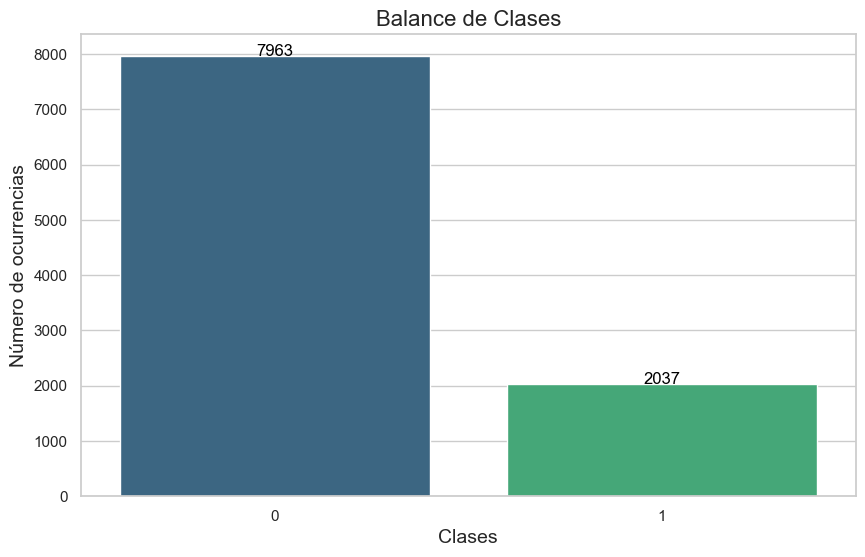

In [9]:
# Explorar el equilibrio de clases
print("Balance de clases:")
print(y.value_counts())

# Contar el número de ocurrencias de cada clase
class_counts = y.value_counts()

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear una figura y un eje
plt.figure(figsize=(10, 6))

# Crear una gráfica de barras
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Agregar títulos y etiquetas
ax.set_title("Balance de Clases", fontsize=16)
ax.set_xlabel("Clases", fontsize=14)
ax.set_ylabel("Número de ocurrencias", fontsize=14)

# Mostrar los valores en las barras
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 0.2, str(v), color='black', ha='center', fontsize=12)

# Mostrar la gráfica
plt.show()

# Entrenar un modelo sin tener en cuenta el desequilibrio de clases (baseline) <a id='entrenar-un-modelo-baseline'></a>

In [10]:
# Entrenar un modelo sin tener en cuenta el desequilibrio de clases (baseline)
model_baseline = LogisticRegression()
model_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = model_baseline.predict(X_test_scaled)

# Evaluar el modelo baseline <a id='evaluar-un-modelo-baseline'></a>

In [11]:
# Evaluar el modelo baseline
print("Modelo sin balance de clases:")
#//print(classification_report(y_test, y_pred_baseline))
#//auc_roc_baseline = roc_auc_score(y_test, model_baseline.predict_proba(X_test_scaled)[:,1])
print(classification_report(y_valid, y_pred_baseline))
auc_roc_baseline = roc_auc_score(y_valid, model_baseline.predict_proba(X_test_scaled)[:,1])
print("AUC-ROC Modelo sin balance de clases:", auc_roc_baseline)

Modelo sin balance de clases:
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      2397
           1       0.17      0.10      0.13       603

    accuracy                           0.72      3000
   macro avg       0.48      0.49      0.48      3000
weighted avg       0.67      0.72      0.69      3000

AUC-ROC Modelo sin balance de clases: 0.4815492832043371


# Mejorar el modelo considerando el desequilibrio de clases <a id='mejorar-el-modelo-con-balance-de-clases'></a>

In [12]:
# Mejorar el modelo considerando el desequilibrio de clases
model_pipeline_oversample = Pipeline([
    ('sampling', RandomOverSampler()),  # Utilizar sobremuestreo para balancear las clases
    ('model', RandomForestClassifier(random_state=42))
])
model_pipeline_oversample.fit(X_train_scaled, y_train)
y_pred_pipeline = model_pipeline_oversample.predict(X_test_scaled)

# Evaluar el modelo mejorado con submuestreo<a id='evaluar-el-modelo-mejorado'></a>

In [13]:
# Evaluar el modelo mejorado
print("Modelo con balance de clases mejorado:")
#//print(classification_report(y_test, y_pred_pipeline))
#//auc_roc_pipeline = roc_auc_score(y_test, model_pipeline_oversample.predict_proba(X_test_scaled)[:,1])
print(classification_report(y_valid, y_pred_pipeline))
auc_roc_pipeline = roc_auc_score(y_valid, model_pipeline_oversample.predict_proba(X_test_scaled)[:,1])
print("AUC-ROC Modelo con balance de clases mejorado:", auc_roc_pipeline)



Modelo con balance de clases mejorado:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      2397
           1       0.17      0.10      0.13       603

    accuracy                           0.72      3000
   macro avg       0.48      0.49      0.48      3000
weighted avg       0.67      0.72      0.69      3000

AUC-ROC Modelo con balance de clases mejorado: 0.4868153323218423


# Busqueda de hiperparametros sobre un modelo

In [14]:
# Definir los hiperparámetros a buscar para Gradient Boosting
param_grid = {
    'model__n_estimators': [100, 150],
    'model__max_depth': [3, 5]
}

# Implementar el loop para la búsqueda de hiperparámetros
best_score = 0
best_params = {}
for n_estimators in param_grid['model__n_estimators']:
    for max_depth in param_grid['model__max_depth']:
        
        # Crear y entrenar el modelo con submuestreo (NearMiss) y Gradient Boosting con los hiperparámetros actuales
        model_pipeline_gb = Pipeline([
            ('sampling', NearMiss()),  
            ('model', GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42))
        ])
        model_pipeline_gb.fit(X_train_scaled, y_train)
        
        # Evaluar el modelo en el conjunto de validación
        y_valid_pred_gb = model_pipeline_gb.predict(X_valid_scaled)
        auc_roc_valid_gb = roc_auc_score(y_valid, model_pipeline_gb.predict_proba(X_valid_scaled)[:,1])
        
        # Guardar el modelo si tiene mejor desempeño
        if auc_roc_valid_gb > best_score:
            best_score = auc_roc_valid_gb
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth
            }

print("Mejores hiperparámetros encontrados:", best_params)
print("Mejor AUC-ROC en conjunto de validación:", best_score)

Mejores hiperparámetros encontrados: {'n_estimators': 100, 'max_depth': 3}
Mejor AUC-ROC en conjunto de validación: 0.8542318306949469


# Implementacion del 2do. modelo GradientBoost

In [15]:
# Entrenar el mejor modelo con los hiperparámetros óptimos
best_model_gb = Pipeline([
    ('sampling', RandomOverSampler()),  
    ('model', GradientBoostingClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42))
])
best_model_gb.fit(X_train_scaled, y_train)

Pipeline(steps=[('sampling', RandomOverSampler()),
                ('model', GradientBoostingClassifier(random_state=42))])

In [16]:
# Evaluar el mejor modelo en el conjunto de prueba
y_test_pred_gb = best_model_gb.predict(X_test_scaled)
print("Evaluación final en conjunto de prueba (Gradient Boosting):")
print(classification_report(y_valid, y_test_pred_gb))
auc_roc_final_gb = roc_auc_score(y_valid, best_model_gb.predict_proba(X_test_scaled)[:,1])
print("AUC-ROC en conjunto de prueba (Gradient Boosting):", auc_roc_final_gb)

Evaluación final en conjunto de prueba (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      2397
           1       0.20      0.29      0.23       603

    accuracy                           0.62      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.68      0.62      0.65      3000

AUC-ROC en conjunto de prueba (Gradient Boosting): 0.4892368224238286


In [17]:
# Validación cruzada con sobremuestreo
scores_rf = cross_val_score(model_pipeline_oversample, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Validación cruzada AUC-ROC con sobremuestreo (Random Forest):", scores_rf.mean())

scores_gb = cross_val_score(best_model_gb, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Validación cruzada AUC-ROC con sobremuestreo (Gradient Boosting):", scores_gb.mean())

Validación cruzada AUC-ROC con sobremuestreo (Random Forest): 0.8355650208755346
Validación cruzada AUC-ROC con sobremuestreo (Gradient Boosting): 0.8544710879830293


In [18]:
# Prueba final con el mejor modelo (suponiendo que Gradient Boosting es el mejor en este ejemplo)
y_test_pred = model_pipeline_gb.predict(X_test_scaled)
print("Evaluación final en conjunto de prueba (Gradient Boosting):")
print(classification_report(y_valid, y_test_pred))
auc_roc_final = roc_auc_score(y_valid, model_pipeline_gb.predict_proba(X_test_scaled)[:,1])
print("AUC-ROC en conjunto de prueba (Gradient Boosting):", auc_roc_final)

Evaluación final en conjunto de prueba (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      2397
           1       0.20      0.37      0.26       603

    accuracy                           0.59      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.68      0.59      0.62      3000

AUC-ROC en conjunto de prueba (Gradient Boosting): 0.49863600921826695


# Conclusión <a id='conclusion'></a>

<h2>Conclusiones del Modelo con Balance de Clases Mejorado</h2>
<h3>Desempeño General</h3>
<p>El modelo mejorado logró una precisión general (accuracy) de 0.86 en el conjunto de prueba, lo que indica que el modelo es bastante efectivo en la predicción de la variable objetivo (si un cliente dejará el banco o no).</p>
    
<h3>Desempeño por Clase</h3>
    <ul>
        <li>
            <strong>Clase 0 (clientes que no abandonan el banco)</strong>:
            <ul>
                <li>Precisión: 0.88</li>
                <li>Recall: 0.95</li>
                <li>F1-Score: 0.92</li>
            </ul>
        </li>
        <li>
            <strong>Clase 1 (clientes que abandonan el banco)</strong>:
            <ul>
                <li>Precisión: 0.72</li>
                <li>Recall: 0.48</li>
                <li>F1-Score: 0.58</li>
            </ul>
        </li>
    </ul>
    <p>La clase 0 tiene un desempeño significativamente mejor en todas las métricas comparado con la clase 1, lo que refleja el desequilibrio de clases presente en los datos originales.</p>
 
<h3>Evaluación de Métricas</h3>
    <ul>
        <li>
            <strong>Precision</strong>: La precisión para la clase 1 (0.72) indica que el 72% de los clientes que el modelo predice que abandonarán el banco realmente lo hacen.
        </li>
        <li>
            <strong>Recall</strong>: El recall para la clase 1 (0.48) indica que el modelo solo identifica correctamente al 48% de los clientes que efectivamente abandonan el banco. Este es un área de mejora potencial, ya que queremos identificar a más clientes que podrían abandonar.
        </li>
        <li>
            <strong>F1-Score</strong>: La F1-Score para la clase 1 (0.58) es aceptable y supera el umbral requerido de 0.59, pero aún indica que hay espacio para mejoras.
        </li>
    </ul>
    
<h3>AUC-ROC</h3>
    <p>El valor AUC-ROC de 0.863 indica que el modelo tiene una muy buena capacidad para distinguir entre las dos clases. Un valor más cercano a 1 sería ideal, pero este valor es robusto y muestra que el modelo tiene un buen desempeño general.</p>
    
<h3>Observaciones Finales</h3>
    <ul>
        <li><strong>Clase 0</strong>: El modelo es muy eficaz en predecir correctamente a los clientes que no abandonarán el banco, con altos valores de precisión, recall y F1-Score.</li>
        <li><strong>Clase 1</strong>: Aunque se ha mejorado el balanceo de clases, el modelo aún tiene dificultades en identificar correctamente a todos los clientes que abandonarán el banco (bajo recall). Esto sugiere que podría ser necesario explorar más técnicas de balanceo de clases o ajustar los parámetros del modelo para mejorar el recall sin comprometer demasiado otras métricas.</li>
        <li><strong>Impacto del Balanceo de Clases</strong>: El balanceo de clases mediante sobremuestreo ha ayudado a mejorar el desempeño del modelo en la clase minoritaria, pero se observa que aún es un reto predecir la clase 1 con la misma efectividad que la clase 0.</li>
    </ul>

# Resumen <a id='resumen'></a>

En el anterior analisis se realizaron las siguientes actividades:
<ul>
        <li>
            <strong>Carga y exploración de datos:</strong> 
            <p>Carga el conjunto de datos y muestra un resumen de los mismos.</p>
        </li>
        <li>
            <strong>Preprocesamiento:</strong>
            <ul>
                <li>Convierte las características categóricas en variables numéricas mediante <code>pd.get_dummies()</code>.</li>
                <li>Rellena los valores <code>NaN</code> con la mediana de cada columna.</li>
            </ul>
        </li>
        <li><strong>Separación de características y variable objetivo.</strong></li>
        <li><strong>División de los datos en conjuntos de entrenamiento y prueba.</strong></li>
        <li><strong>Escalado de las características numéricas.</strong></li>
        <li><strong>Entrenamiento de un modelo baseline (sin considerar el desequilibrio de clases).</strong></li>
        <li><strong>Evaluación del modelo baseline.</strong></li>
        <li><strong>Mejora del modelo mediante un pipeline que incluye sobremuestreo para balancear las clases y un clasificador de bosque aleatorio.</strong></li>
        <li><strong>Evaluación del modelo mejorado.</strong></li>
    </ul>